In [ ]:
!pip -q install timm grad-cam

# Start

In [2]:
import torch
from torch import nn
import timm
import timm.scheduler
from pathlib import Path
from PIL import Image, ImageDraw, ImageChops
import pandas as pd
# from torchinfo import summary
# import torchmetrics
from datetime import datetime as dt
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature,morphology
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu, threshold_niblack,threshold_sauvola, scharr
from skimage.measure import label, regionprops, regionprops_table
import os, json

#import torch_xla.utils.serialization as xser
#from torch.utils.tensorboard import SummaryWriter

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.cuda.set_device(0)
!nvidia-smi -L

GPU 0: NVIDIA RTX A6000 (UUID: GPU-bfdc5639-c459-d93b-fb1f-91482b768129)
GPU 1: NVIDIA RTX A6000 (UUID: GPU-aa6081a7-5960-f4f8-d4dc-b5ce36cb1976)


In [3]:
# for google colab (ignore)
try:
    from google.colab import drive
    drive.mount('./drive')
    dfname = "drive/MyDrive/00shared_projects/MDS/MDSAK5List-WSI.csv"
    !unzip -q -o drive/MyDrive/00shared_projects/MDS/230115WSI_mask.zip -d .
    !ls drive
except:
    pass

In [4]:
config ={}

# csv file name containing patient information
config['dfname'] = "MDSAK5List-WSI.csv"

# Load the dataset from the specified CSV file
df = pd.read_csv(config['dfname'])

# Define the target labels
target_labels = ['anemia', 'MDS']

# Create a new column 'age_med' which is True if 'age' is greater than the median age, otherwise False
print("median age:",df['age'].median())
df['age_med'] = df['age'] > df['age'].median()

# Convert 'ID' column to string type and set it as the index
df['ID'] = df['ID'].astype(int).astype(str)
df = df.set_index('ID', drop=False)

# Convert target label columns to integer type and print the sum of each label
for t in target_labels:
    df[t] = df[t].astype(int)
    print(t, df[t].sum())

# Print the total number of records
print('all', len(df))
df.head(10)

median age: 72.5
anemia 20
MDS 21
all 42


,ID,age,MDS,anemia,date_of_creation,WBC,RBC,Hct,Hb,MCV,Plt,age_med
ID,,,,,,,,,,,,
1416,1416,82,1,1,20200318,4900,225,24.2,7.5,108,0.4,True
17805,17805,72,1,0,20210212,2500,332,31.2,10.1,94,9.9,False
20914,20914,90,1,1,20220624,5500,248,24.7,7.4,100,19.2,True
23789,23789,69,1,1,20210618,3800,311,28.8,8.3,93,8.3,False
46903,46903,78,1,1,20220215,4200,227,24.7,7.5,109,2.9,True
47743,47743,60,0,0,20210929,5600,435,39.4,12.9,91,29.6,False
51237,51237,78,0,0,20180807,6600,422,40.5,13.7,96,25.3,True
58814,58814,64,1,1,20190507,3900,189,20.6,6.5,109,14.9,False
61609,61609,65,1,0,20200324,3200,306,34.8,11.5,114,37.5,False


## utility functions

In [5]:
from tqdm.auto import tqdm
import time
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# prediction by voting (crop => img,  => patient)
def voting_prediction(results, suffix=0, groupby="filename", filename=None):
    sresults = []
    correct = {l:0 for l in target_labels}
    total = 0
    if groupby =="filename":
        groups = data_path # image file
    elif groupby=='patient':
        groups = df.ID.values # patients
        
    for gp in groups:
        sdf = results[results[groupby]==gp]
        if len(sdf)>0:
            sresults.append({groupby:gp})
            for l in target_labels:
                label = sdf[l].iloc[0]
                score = sum(sdf[f'score_{l}'])/len(sdf) # mean score
                prediction = (score>0.5)
                sresults[-1].update({l:label, f'CV_{suffix}': sdf['CV'].iloc[0], f'pred_{l}_{suffix}': prediction, f'score_{l}_{suffix}':score})
                correct[l] += (prediction==label).sum()
            total += 1
    #summary    
    acc ={l: correct[l]/total for l in target_labels}
    #print(f'Acc: {acc}, Correct: {correct}, Total: {len(data_path)}')
    sresults = pd.DataFrame(sresults).sort_values(groupby).set_index(groupby)
    if filename is not None:
        sresults.to_csv(filename,index=True)
    return(sresults, acc)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


## train-validate

In [6]:
##
criterion = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
def train(model, device, train_loader, optimizer, epoch, use_tqdm=True):
    # statistics recoder
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = {l:AverageMeter() for l in target_labels}

    # start training over batch
    model.train()
    end = time.time()
    # if xm.is_master_ordinal():
    #     dataloader = tqdm(dataloader)
    #     dataloader.set_description("title")
    if use_tqdm:
        progress_bar = tqdm(train_loader)
    else:
        progress_bar = train_loader

    for i, (data, extvar, targets) in enumerate(progress_bar):
        if use_tqdm:
            progress_bar.set_description('Epoch ' + str(epoch))
        data_time.update(time.time() - end)
        data = data.to(device,non_blocking=True)
        extvar = extvar.to(device,non_blocking=True)
        #print(data,targets)

        outputs = model(data,extvar)
        #print(outputs, targets)
        target = targets.to(device)
        loss = 0
        for col,l in enumerate(target_labels):
          loss = loss + criterion(outputs[col], target[:,col])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #xm.optimizer_step(optimizer)

        batch_time.update(time.time() - end)
        end = time.time()

        losses.update(loss.detach().cpu().numpy(), data.size(0))
        for col,l in enumerate(target_labels):    
          acc1 = accuracy(outputs[col], target[:,col], topk=(1,))[0]
          top1[l].update(acc1.detach().cpu().numpy()[0], data.size(0))

        #if xm.is_master_ordinal():
        if use_tqdm:
          progress_bar.set_postfix(
              #'epoch: [{0}][{1}/{2}]\t'
              #'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              #'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
              Loss1='{:.4f}'.format(losses.avg),
              Acc1='{:.4f}'.format(top1[target_labels[0]].avg),
              Acc2='{:.4f}'.format(top1[target_labels[1]].avg),
              )

    return(losses,top1)

# Validation
def validate(model, device, val_loader, use_tqdm=True):
    losses = AverageMeter()
    top1 = {l:AverageMeter() for l in target_labels}
    result = {l:[] for l in target_labels}
    model.eval()
    with torch.no_grad():
        for i, (data, extvar, targets) in enumerate(val_loader):
            data = data.to(device,non_blocking=True)
            extvar = extvar.to(device,non_blocking=True)
            outputs = model(data,extvar)
            target = targets.to(device)
            loss = 0
            for col,l in enumerate(target_labels):
              loss = loss + criterion(outputs[col], target[:,col])
              acc1 = accuracy(outputs[col], target[:,col], topk=(1,))[0]
              top1[l].update(acc1.detach().cpu().numpy()[0], data.size(0))

            losses.update(loss.detach().cpu().numpy(), data.size(0))
            for col,l in enumerate(target_labels):
              result[l].append(outputs[col].detach().cpu().numpy())
    if use_tqdm:
      tqdm.write(f'Test: Loss1 ({losses.avg:.4f})'.join([f'\tAcc_{l} ({top1[l].avg:.3f})' for l in target_labels]))
    return losses, top1, [np.concatenate(result[l], axis=0) for l in target_labels]


In [7]:
## model fitting
def fit_cnn(train_data, test_data, log_writer=None, use_tqdm=False, eval_every=10, save_model_name=None):
  results = []
  history = {split: {phase: dict(**{'loss':[]},**{f'acc_{l}':[] for l in target_labels}) for phase in phases} for split in range(config['n_splits'])}
  if log_writer is not None:
    use_tqdm = True
  for fold in range(config['n_splits']):
    model = myModel(config['model_name'],config['update'],config['hidden_dim'],num_heads=len(target_labels),num_external=config['num_external'])
    #model = timm.create_model(model_name, pretrained=True)
    #freeze_pretrained_layers(model)
    model.to(device)
    #config = resolve_data_config({}, model=model_name)
    #base_transform = create_transform(**config)
    #print('\nbase_transform\n', base_transform)
    #model.default_cfg
    #summary(model,input_size = (64, 3, 224, 224))

    optimizer = torch.optim.SGD(model.param_to_update, lr=config['lr'])
    #optimizer = torch.optim.AdamW(model.param_to_update, lr=lr)
    #optimizer = torch.optim.NAdam(model.param_to_update, lr=lr, weight_decay=1e-5)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[(i+1) * epochs//lr_drop for i in range(lr_drop-1)], gamma=0.1)
    scheduler = timm.scheduler.CosineLRScheduler(optimizer,t_initial=config['epochs'],lr_min=1e-04,t_in_epochs=True,warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)

    trainset = WSIDataset(train_data[fold],training_mode=config['training_mode'],crop_size=config['crop_size'],resize=config['resize'], repeat=config['repeat'], max_cut_area=config['max_cut_area'], check_mean=config['check_mean'], jitter=config['jitter'], channels=config['channels'], blur_sigma=config['blur_sigma'],num_external=config['num_external'])
    testset = WSIDataset(test_data[fold], training_mode="val",crop_size=config['crop_size'],resize=config['resize'], check_mean=config['check_mean'], jitter=config['jitter'], channels=config['channels'], blur_sigma=config['blur_sigma'],num_external=config['num_external'])
    train_dataloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=True)
    test_dataloader = DataLoader(testset, batch_size=config['batch_size'], num_workers=config['num_workers'], pin_memory=True)
    if log_writer:
      print(f'Fold {fold}, Train {len(trainset)}, Test {len(testset)}')

    for epoch in range(config['epochs']):
      loss, acc = train(model, device, train_dataloader, optimizer, epoch, use_tqdm=use_tqdm)
      scheduler.step(epoch=epoch+1)
      history[fold]['train'][f'loss'].append(loss.avg)
      if log_writer:
          log_writer.add_scalar(f'loss', loss.avg, epoch)
      for l in target_labels:
        history[fold]['train'][f'acc_{l}'].append(acc[l].avg)
        if log_writer:
            log_writer.add_scalar(f'acc_{l}', acc[l].avg, epoch)
            log_writer.flush()
          
      if (epoch+1) % eval_every == 0 or epoch==config['epochs']-1:
          val_loss, val_acc, result = validate(model, device, test_dataloader, use_tqdm=use_tqdm)
          if log_writer:
              log_writer.add_scalar(f'val_loss', val_loss.avg, epoch)
          for l in target_labels:
              history[fold]['test'][f'acc_{l}'].append(val_acc[l].avg)
              if log_writer:
                  log_writer.add_scalar(f'val_acc_{l}', val_acc[l].avg, epoch)
                  log_writer.flush()
          history[fold]['test'][f'loss'].append(val_loss.avg)

    ##
    if log_writer:
        log_writer.close()
    ## save model file
    if save_model_name is not None:
        model_fn = f"{save_model_name}_cv{fold}.pth"
        torch.save(model, model_fn)
    ## save predictions
    #testset = WSIDataset(test_data[fold], is_training=False,crop_size=crop_size,resize=resize)
    #val_loss, val_acc, result = validate(model, device, test_dataloader)
    res = pd.DataFrame({'patient': testset.ids, 'filename': testset.fns, 'loc': testset.loc})
    for col,l in enumerate(target_labels):
      res[l]=[x[col].detach().cpu().numpy().item() for x in testset.labels]
      res[f'score_{l}'] = softmax(result[col],axis=1)[:,1]
    res['CV'] = fold
    results.append(res)

  results = pd.concat(results).sort_values('filename')
  return(results,history)



## NN definition

In [8]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
import re
from timm.data.transforms import RandomResizedCropAndInterpolation
from timm.data.auto_augment import rand_augment_transform
from timm.data.transforms_factory import create_transform 
import torchvision.transforms as transforms
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
#import torch_xla.core.xla_model as xm

class myModel(torch.nn.Module):
  def __init__(self,model_name, update='BN', hidden_dim=512, out_dim=2, num_heads=2, pretrained=True, num_external=0):
    super().__init__()

    model = timm.create_model(model_name, num_classes=0, pretrained=pretrained)

    self.default_cfg = model.default_cfg
    self.backbone = model
    self.in_features = model.num_features+num_external
    self.head = nn.ModuleDict({str(i):nn.Sequential(
        nn.BatchNorm1d(self.in_features),
        nn.Dropout(),
        nn.Linear(self.in_features, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(hidden_dim, out_dim)
    ) for i in range(num_heads)})

    # head is always updated
    self.param_to_update = sum([list(self.head[str(i)].parameters()) for i in range(num_heads)],[])
    #print(len(self.param_to_update))
    if update=='head': # only head; turn off gradient
      for param in self.backbone.parameters():
          param.requires_grad = False
      for param in self.backbone.get_classifier().parameters():
          param.requires_grad = True
    elif update=='BN': # head and BN
      for layer in self.backbone.modules(): ## BN is left unfrozen
          if isinstance(layer, nn.BatchNorm2d):
              self.param_to_update.extend(layer.parameters())
    else: # all
      self.param_to_update.extend(list(self.backbone.parameters()))
    #print(len(self.param_to_update))

  def forward(self,x_img,x_ext=None):
    h = self.backbone(x_img)
    if x_ext is not None:
        h = torch.cat([h,x_ext],axis=1)
    else: # DIRTY
        global label0
        h = torch.cat([h,label0],axis=1)
    #print(h.shape,x_ext.shape)
    y = [self.head[str(i)](h) for i in range(len(self.head))]
    return(y)
    #return(y[1]) ## for gradcam



## dataset processing

In [13]:
# overlap sliding window
def split_image(im, height, width, overlap=0.5):
    imgwidth, imgheight = im.size
    splits = []
    loc = []
    for i in range(0,imgheight-height,int(overlap*height)):
        for j in range(0,imgwidth-width,int(overlap*width)):
            splits.append(im.crop((j, i, j+width, i+height)))
            loc.append([j, i, j+width, i+height])
    return(splits,loc)

# 画像にランダムに穴を開けて脂肪滴をシミュレート
def randomCut(img,max_cut_area=0.2):
  im = img
  draw = ImageDraw.Draw(im)
  w,h = img.size
  M = max_cut_area*np.random.uniform(0,max_cut_area)
  area = 0
  while area < M*w*h:
    x = np.random.randint(0,w)
    y = np.random.randint(0,h)
    r = np.random.randint(min(w,h)//16,min(w,h)//4)
    draw.ellipse((x,y,x+2*r,y+2*r), fill = (233,233,233), outline =(233,233,233))
    area += np.pi*r*r
  return(im)

# 画像の粒度が適切かのチェック
def median_total_area(im,exclude=10):
  img = (np.array(im)[:,:,2]>100)
  #print(img.shape, img.sum(), img.size)
  label_img = label(img) # blue channel 有核細胞のマスク
  props = pd.DataFrame(regionprops_table(label_img, properties=['area']))
  q75, q25 = np.percentile(props['area'], [100-exclude ,exclude])
  props = props[ (props['area'] > q25) & (props['area'] < q75) ] # 除外値
  return(props['area'].mean(),img.sum()/img.size,len(props['area']))
  #return(props['area'].median(),img.sum()/img.size,len(props['area']))


# NOT_USED: simple method to create masks
def create_mask(img,binarisation="fix",blur_sigma=[0,0,0]):
    im = np.array(img.convert('HSV'))
    ## HSV
    if binarisation=='sauvola':
        mask_r = (im[:,:,1] <=threshold_sauvola(im[:,:,1].astype(float)))
        mask_b = (im[:,:,2] <=threshold_sauvola(im[:,:,2].astype(float)))
    elif binarisation=='niblack':
        mask_r = (im[:,:,1] <= threshold_niblack(im[:,:,1].astype(float)))            
        mask_b = (im[:,:,2] <=threshold_sauvola(im[:,:,2].astype(float)))
    elif binarisation=='otsu':
        mask_r = (im[:,:,1] <= threshold_otsu(im[:,:,1].astype(float)))
        mask_b = (im[:,:,2] <=threshold_sauvola(im[:,:,2].astype(float)))
    else:
        mask_r = im[:,:,1]>60 # nucleated cells
        mask_b = (im[:,:,1]<30) & (im[:,:,2]<210) # RBC
    
    #plt.imshow(bw_img,cmap='gray')
    mim = np.array(img)
    mim[:,:,0] = 255*mask_r
    mim[:,:,1] = 0
    mim[:,:,2] = 255*(mask_b & ~mask_r)
    if blur_sigma[0]>0: 
        mim[:,:,0] = gaussian_filter(mim[:,:,0], sigma=blur_sigma[0], mode='nearest')
    if blur_sigma[2]>0: 
        mim[:,:,2] = gaussian_filter(mim[:,:,2], sigma=blur_sigma[2], mode='nearest')
    #Image.fromarray(mim).save(os.path.join("seg",fn.name))
    #masks[fn]=mim[:,:,2]>10
    return(mim)

# dataloader
class WSIDataset(Dataset):
    def __init__(self, data, training_mode="val", crop_size=224, resize=None, repeat=1, overlap=0.5, max_cut_area=0, check_mean=False, jitter=0.2, channels=None, blur_sigma=None, num_external=0):
        self.repeat = repeat
        self.training_mode = training_mode
        self.max_cut_area = max_cut_area
        self.fns = []
        self.labels = []
        self.external = []
        self.images = []
        self.loc = []
        self.fn_to_idx = {}
        idx = 0
        # min_ma, max_ma = 0,10
        # min_ta, max_ta = 0.25, 0.55
        min_ma, max_ma = 0,15
        min_ta, max_ta = 0.02, 1.00
        for x in data: # x = (filename, label(s))
          fn = x[0]
          img = Image.open(fn)
          # select the specified set of channels
          if channels=="org":
              img = img
          elif type(channels)==list:
              img = np.array(img)
              for i in range(3):
                if i not in channels:
                    img[:,:,i]=0
              img = Image.fromarray(img)
          else:
              img = create_mask(img,blur_sigma=blur_sigma) # create mask by thresholding
              #R,G,B = img.split()
              #empty = Image.new("L", img.size, "black")
              if channels=="nuc":
                #img = Image.merge("RGB", (R, R, R)) #empty, empty))
                img = Image.fromarray(np.tile(img[:,:,[0]],(1,3)))
              elif channels=="red":
                img = Image.fromarray(np.tile(img[:,:,[2]],(1,3)))
              elif channels=="red_nuc":
                img = Image.fromarray(img)
              else:
                print("unknown target channel!")
          # resize
          if resize is not None:
            img = img.resize(resize, Image.Resampling.LANCZOS)
          # apply crop and augmentation
          if training_mode=="random":
            self.fns.append(fn)
            self.images.append(img)
            self.labels.append(x[1:]) # label flag
            #self.labels.append(x[(num_external+1):]) # flag
            self.external.append(x[1:(num_external+1)]) # flag
            self.loc.append([np.nan,np.nan])
            self.fn_to_idx[str(fn)] = [idx]
            idx += 1
          elif training_mode=="crop":
            self.fn_to_idx[str(fn)] = []
            for im,loc in zip(*split_image(img, int(crop_size*1.2), int(crop_size*1.2), overlap=overlap)):
              if check_mean:
                ma,ta=median_total_area(im)
                if ma<min_ma or ma>max_ma or ta<min_ta or ta>max_ta:
                  continue
              self.fns.append(fn)
              self.images.append(im)
              self.labels.append(x[1:]) # label flag
              #self.labels.append(x[(num_external+1):]) # flag
              self.external.append(x[1:(num_external+1)]) # flag
              self.loc.append(loc)
              self.fn_to_idx[str(fn)].append(idx)
              idx += 1
          elif training_mode=="val":
            self.fn_to_idx[str(fn)] = []
            for im,loc in zip(*split_image(img, crop_size, crop_size, overlap=overlap)):
              if check_mean:
                ma,ta=median_total_area(im)
                #print(fn,ma,ta)
                if ma<min_ma or ma>max_ma or ta<min_ta or ta>max_ta:
                  continue
              self.fns.append(fn)
              self.images.append(im)
              self.labels.append(x[1:]) # label flag
              #self.labels.append(x[(num_external+1):]) # MDS flag
              self.external.append(x[1:(num_external+1)]) # flag
              self.loc.append(loc)
              self.fn_to_idx[str(fn)].append(idx)
              idx += 1
          else:
            print(f"unknown mode {training_mode}!")

        self.labels = torch.LongTensor(self.labels)
        self.external = torch.LongTensor(self.external)
        self.n = len(self.fns)

        #self.transform = create_transform(224, is_training=is_training)
        normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
        transform = transforms.Compose([])
        if training_mode=="random":
          transform.transforms.append(transforms.RandomRotation(10))
          transform.transforms.append(transforms.RandomCrop(int(crop_size*1.2))) # 境界が入りにくいように少し広めに切り取っておく
          transform.transforms.append(transforms.Lambda(lambda im: randomCut(im,self.max_cut_area)))
          transform.transforms.append(transforms.CenterCrop(crop_size))
          transform.transforms.append(transforms.RandomHorizontalFlip())
          transform.transforms.append(transforms.RandomVerticalFlip())
          transform.transforms.append(transforms.ColorJitter(brightness=jitter, contrast=jitter, saturation=jitter))
        elif training_mode=="crop":
          transform.transforms.append(transforms.RandomCrop(int(crop_size)))
          transform.transforms.append(transforms.RandomHorizontalFlip())
          transform.transforms.append(transforms.RandomVerticalFlip())
        else:
          transform.transforms.append(transforms.CenterCrop(crop_size))
        transform.transforms.append(transforms.ToTensor())
        transform.transforms.append(normalize)
        # if is_training:
        #   transform.transforms.append(transforms.RandomErasing())
        self.transform = transform
        
        # patient ID
        pt = re.compile(r"(.+)_(\d+)_")
        self.ids = [pt.findall(fn.name)[0][0] for fn in self.fns]
        # check if at least one image is included from all patients
        all_ids = [pt.findall(x[0].name)[0][0] for x in data]
        if len(set(all_ids))!=len(set(self.ids)):
            print("Some patients are missing due to check_mean!")
            print(all_ids,self.ids)

    def __getitem__(self, index):
        i = index % self.n
        img = self.images[i]
        return self.transform(img),self.external[i], self.labels[i]

    def area(self, index):
        i = index % self.n
        img = self.images[i]
        R,G,B = img.split()
        area = ((np.array(R)>100).sum(),(np.array(B)>100).sum())
        return area, self.labels[i]

    def __len__(self):
        return self.n*self.repeat

           
# splitting image file names stratified w.r.t. labels
def train_test_splitter(n_splits,random_state):
  pattern = re.compile(r'.+\/(\d+)', re.VERBOSE)
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
  train_data=[]
  test_data=[]

  for train_index, test_index in skf.split(df['ID'], df['age_med']):
    train_data.append([])
    test_data.append([])
    for fn in data_path:
        pt = pattern.search(str(fn))
        idx = pt.group(1)
          #print(fn, idx)
        if idx in df['ID'].iloc[train_index].values:
            #print([(df.loc[idx,l]) for l in target_labels])
            train_data[-1].append([fn]+[int(df.loc[idx,l]) for l in target_labels])
        else:
            try:
                test_data[-1].append([fn]+[int(df.loc[idx,l]) for l in target_labels])
            except:
                print(f"{idx} is not found in the DataFrame")
    #print(f'train: {len(train_data[-1])}, test: {len(test_data[-1])}')
  return(train_data,test_data)

## Analysis by NN

In [15]:
## settings

config['model_name'] = "efficientnet_b0"
#model_name = 'resnet50d'
#model_name = 'efficientnetv2_rw_s'
#model_name = "tf_efficientnetv2_m_in21k"
#model_name = 'vit_tiny_patch16_224'
#model_name = 'swin_small_patch4_window7_224'
config['update'] = 'BN' # conv layer のうち BN だけ学習
config['hidden_dim']=512 # FC の hidden dim

config['num_external'] = 1 # 'anemia' is used as external variable

config['imgmode']="x40_mask" # ["x5", "x40", "x40_mask"]

## image files will be loaded from this dir. We will provide image files upon a reasonable request.
config['image_root'] = f"230922{config['imgmode']}"

## training parameters
config['lr'] = 1e-2
config['epochs']=20   # 20 is good, 30 は overfit
config['lr_drop']=3
config['batch_size'] = 32
config['num_workers'] = 0
config['repeat'] = 30 # training data を repeat して水増し
config['training_mode'] = "crop" # "random"
config['check_mean'] = False
config['random_state']=42

phases = ['train','test']
config['n_splits'] = 3
data_path = sorted([fn for fn in Path(config['image_root']).iterdir() if fn.suffix in ['.jpg','.png']]) # , key = lambda x: int(x.name))

## original vs mask
config['channels'] = "org" # 利用するチャンネル: "red","nuc","red_nuc" (on the fly by thresholding),"org"(=元画像)

if "mask" in config['imgmode']:
    config['channels'] = [2] # [0,1,2] 利用するチャンネル: R(有核),G(核),B(赤血球) channels: [0,1] or [2]

if config['channels'] == "org":
    config['jitter'] = 0.3 # 色の jitter
    config['blur_sigma'] = [0,0,0]
else:
    config['jitter'] = 0
    config['blur_sigma'] = [5,0,0] # sigma for R(nuc),G,B(red) channels
    
## crop_size と resize でどれくらいの視野を取るか決める．精度への影響大
if config['imgmode']=="x5":
    ### 5倍画像
    config['resize_ratio'] = 1/3
    config['resize'] = (int(1920*config['resize_ratio']),int(1088*config['resize_ratio']))
    #resize = (270,270)
    #resize = None
    config['crop_size']=224
    config['max_cut_area'] = 0.5 # simulated 脂肪滴の最大割合: 0.5?
elif "x40" in config['imgmode']:
    ### 40倍画像
    config['resize_ratio'] = 1/3
    config['resize'] = (int(1920*config['resize_ratio']),int(1088*config['resize_ratio']))
    config['crop_size']=224
    config['max_cut_area'] = 0.5 # simulated 脂肪滴の最大割合
else:
    print("unknown!")

        
train_data, test_data = train_test_splitter(config['n_splits'],config['random_state'])
print("(Train,val) images for each fold",[(len(x),len(y)) for x,y in zip(train_data,test_data)])

print(f"resize: {config['resize']}, crop: {config['crop_size']}, {config['imgmode']}, {config['channels']}")
#train_data[0][:10]

(Train,val) images for each fold [(140, 70), (140, 70), (140, 70)]
resize: (640, 362), crop: 224, x40_mask, [2]


### multiple trials

In [ ]:
# split を変えて繰り返す
val_acc = {l: [] for l in target_labels}
final = None
config['n_trials'] = 20
config['start_seed'] = 0

torch.backends.cudnn.benchmark = True
for i,random_state in enumerate(tqdm(range(config['start_seed'],config['start_seed']+config['n_trials']))):
    train_data, test_data = train_test_splitter(config['n_splits'],config['random_state'])
    use_tqdm = True if i==0 else False
    use_tqdm=False
    results, history = fit_cnn(train_data, test_data, log_writer=None, use_tqdm=use_tqdm, eval_every=5)
    sresults, acc = voting_prediction(results,groupby='patient',suffix=random_state)
    #sresults = sresults.rename(columns={'CV': f'CV_{random_state}','pred': f'pred_{random_state}','conf': f'conf_{random_state}'})
    if final is None:
        final = sresults
    else:
        #sresults = sresults[[f'CV_{random_state}',f'pred_{random_state}', f'conf_{random_state}']]
        sresults = sresults.drop(columns=target_labels)
        final = pd.merge(final, sresults, left_index=True, right_index=True)  
    for l in target_labels:
        val_acc[l].append(acc[l])
    tqdm.write("".join([f'Acc_{l} ({acc[l]:.4f})\t' for l in target_labels]))


dtstr = dt.now().strftime('%Y_%m%d_%H%M')
#print(final.head())
os.makedirs("log",exist_ok=True)
result_name=os.path.join(f"log/{dtstr}_{config['imgmode']}_{config['channels']}.csv")
final.to_csv(result_name)

df_valacc=pd.DataFrame(dict(**{'phase':"val"},**{f"acc_{l}": val_acc[l] for l in target_labels}))
fname=os.path.join(f"log/{dtstr}_{config['imgmode']}_{config['channels']}_acc.csv")
df_valacc.to_csv(fname)

dic_name=os.path.join(f"log/{dtstr}_{config['imgmode']}_{config['channels']}.json")
with open(dic_name, 'w') as file:
     file.write(json.dumps(config)) # use `json.loads` to do the reverse


In [ ]:
# plot loss transitions
metrics = history[0]['train'].keys() #['loss','acc']
fig, axs = plt.subplots(config["n_splits"],len(metrics),figsize=(5*len(metrics),5*config["n_splits"]))
for fold in range(config["n_splits"]):
  for i,m in enumerate(metrics):
      for phase in phases:
          axs[fold,i].plot(history[fold][phase][m], label=phase)
      axs[fold,i].legend()
      axs[fold,i].set_title(f'CV {fold}, {m}')


### result summary

In [19]:
df_pred = pd.read_csv(result_name)
df_summary = {}
for patient in df_pred['patient']:
    sdf = df_pred[df_pred['patient']==patient].iloc[0]
    MDS_med_score = np.median([sdf[f'score_MDS_{i}'] for i in range(config['n_trials'])])
    anemia_med_score = np.median([sdf[f'score_anemia_{i}'] for i in range(config['n_trials'])])
    df_summary[patient] = {'MDS': sdf['MDS'], 'anemia': sdf['anemia'], 
                           'MDS_median': MDS_med_score, 
                           'anemia_median': anemia_med_score,
                           'MDS_correct': (MDS_med_score>0.5)==(sdf['MDS']>0.5),
                           'anemia_correct': (anemia_med_score>0.5)==(sdf['anemia']>0.5),
                          }

df_summary=pd.DataFrame(df_summary).T
df_summary.to_csv(os.path.splitext(result_name)[0]+".summary.csv")
df_summary

,MDS,anemia,MDS_median,anemia_median,MDS_correct,anemia_correct
1416,1,1,0.722766,0.867958,True,True
16218,1,1,0.483679,0.729348,False,True
17805,1,0,0.884716,0.409753,True,True
200104,0,0,0.056069,0.005165,True,True
200444,1,0,0.866185,0.251362,True,True
200550,1,1,0.999173,0.999638,True,True
208671,0,0,0.11781,0.000968,True,True
208904,1,0,0.2246,0.101692,False,True
20914,1,1,0.916114,0.834915,True,True
211750,1,0,0.724398,0.185137,True,True


# Supplemental

## single trial (for tuning, save model)

In [ ]:
## train once
random_state = 42
train_data, test_data = train_test_splitter(config['n_splits'],config['random_state'])

## logger
dtstr = dt.now().strftime('%Y_%m%d_%H%M')
#logdir_name=f"/content/drive/MyDrive/colab_log
logdir_name="log"
#log_writer = SummaryWriter(log_dir=logdir_name)
log_writer = None

save_model_name = f"{dtstr}"

results, history = fit_cnn(train_data, test_data, log_writer,save_model_name=save_model_name)
result_name=os.path.join(logdir_name,f"result.csv")
results.to_csv(result_name,index=False)
print(results.head())
sresult_name=os.path.join(logdir_name,"summary.csv")
sres, acc = voting_prediction(results,filename=sresult_name)
print(sres.head(),"\n",acc)

dic_name=os.path.join(logdir_name,f"{dtstr}_{config['imgmode']}_{config['channels']}.json")
with open(dic_name, 'w') as file:
     file.write(json.dumps(config)) # use `json.loads` to do the reverse


## GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9888889..2.1154423].


torch.Size([16, 3, 224, 224])


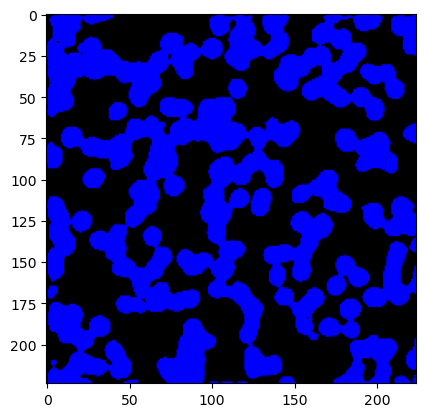

In [45]:
fold=0
testset = WSIDataset(test_data[fold], training_mode="val",crop_size=config['crop_size'],resize=config['resize'], overlap=1, check_mean=config['check_mean'], jitter=config['jitter'], channels=config['channels'], blur_sigma=config['blur_sigma'],num_external=config['num_external'])
test_dataloader = DataLoader(testset, batch_size=16, num_workers=config['num_workers'], pin_memory=True)
input_tensor,label0,label1 = next(iter(test_dataloader))
input_tensor=input_tensor.to(device)
label0 = label0.to(device)
print(input_tensor.shape)
plt.imshow(input_tensor[0].cpu().numpy().transpose(1,2,0))

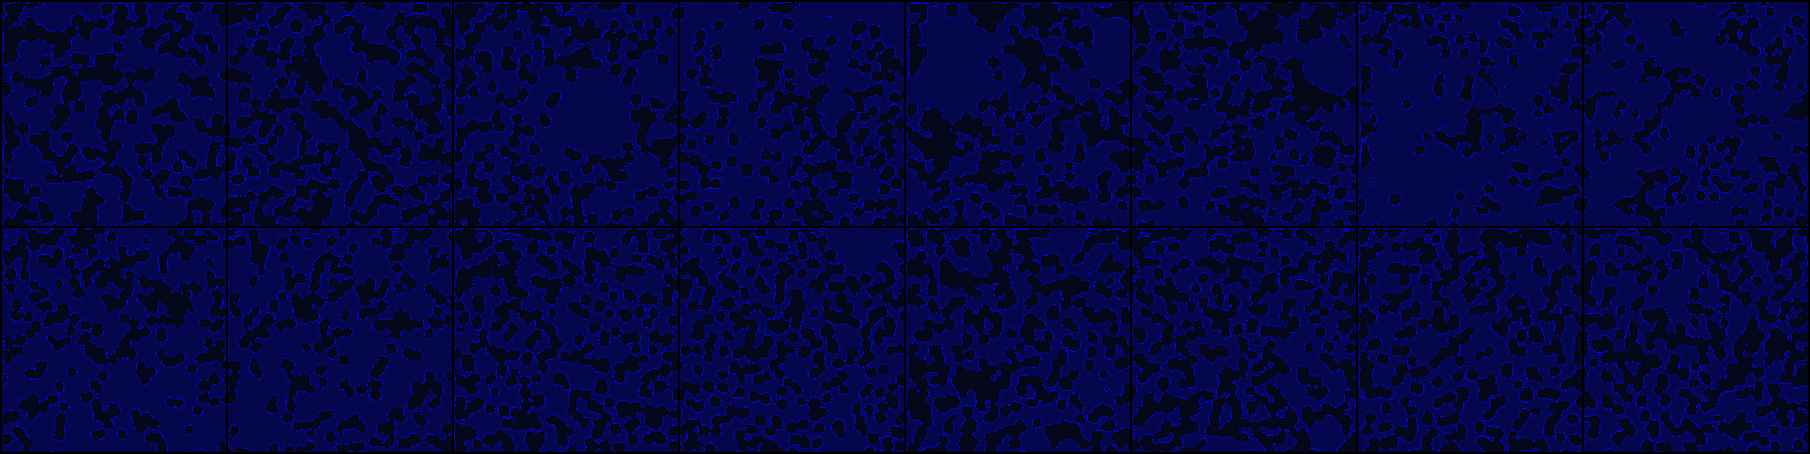

In [46]:
import torchvision
from IPython.display import display
img = torchvision.utils.make_grid(input_tensor[:16],normalize=False)
img = transforms.functional.to_pil_image(img)
display(img)


In [30]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

save_model_name = "log/classification_model.pth"
#model = myModel(config['model_name'],config['update'],config['hidden_dim'],num_heads=len(target_labels),num_external=config['num_external'])
model = torch.load(save_model_name)
model.to(device)

target_layers = [model.backbone.conv_head]
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(1)]

for i,(input_tensor,label0,label1) in tqdm(enumerate(dl)):
    if label1[0][0]==0:
        continue
    input_tensor=input_tensor.to(device)
    label0 = label0.to(device)    
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = input_tensor.cpu().numpy()[0].transpose((1,2,0))
    rgb_img -= rgb_img.min()
    rgb_img /= rgb_img.max()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # You can also get the model outputs without having to re-inference
    model_outputs = cam.outputs
    #plt.imshow(visualization)
    plt.imsave(f"log/gradcam_{i}.jpg",visualization)
    plt.close()

0it [00:00, ?it/s]

## conventional analysis

In [48]:
data = train_data[0]+test_data[0]
dfs = []
for x in tqdm(data): # x = (filename, label(s))
    fn = x[0]
    img = np.array(Image.open(fn))
    a,b,c=median_total_area(img, exclude=20)
    dfs.append({'name': fn, 'mean_size': a, 'area_ratio': b, 'num_components':c, 'anemia': x[1], 'MDS': x[2]})
dfs = pd.DataFrame(dfs)
dfs


  0%|          | 0/210 [00:00<?, ?it/s]

,name,mean_size,area_ratio,num_components,anemia,MDS
0,230922x40_mask/17805_40_1.png,1479.529412,0.321460,136,0,1
1,230922x40_mask/17805_40_2.png,1323.727273,0.271123,143,0,1
2,230922x40_mask/17805_40_3.png,1319.256579,0.297484,152,0,1
3,230922x40_mask/17805_40_4.png,1221.322751,0.291096,189,0,1
4,230922x40_mask/17805_40_5.png,1398.475177,0.337345,141,0,1
...,...,...,...,...,...,...
205,230922x40_mask/89995_40_1.png,1091.356364,0.389349,275,0,0
206,230922x40_mask/89995_40_2.png,1406.342995,0.423931,207,0,0
207,230922x40_mask/89995_40_3.png,2808.375000,0.459346,88,0,0
208,230922x40_mask/89995_40_4.png,2384.235955,0.438905,89,0,0


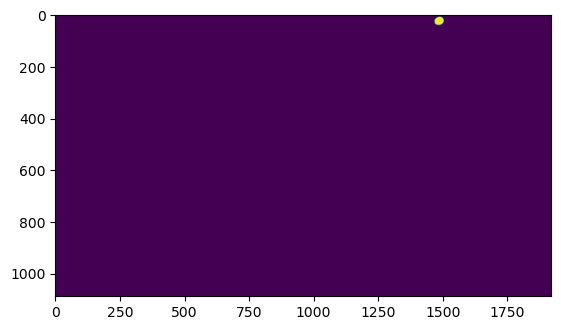

In [49]:
exclude=20
label_img = label(np.array(img)[:,:,2]>100) # blue channel 有核細胞のマスク
props = pd.DataFrame(regionprops_table(label_img, properties=['area']))
q75, q25 = np.percentile(props['area'], [100-exclude ,exclude])
props = props[ (props['area'] > q25) & (props['area'] < q75) ] # 除外値
plt.imshow(label_img==16)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.269e-03 U_stat=1.112e+03
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.713e-01 U_stat=1.164e+03


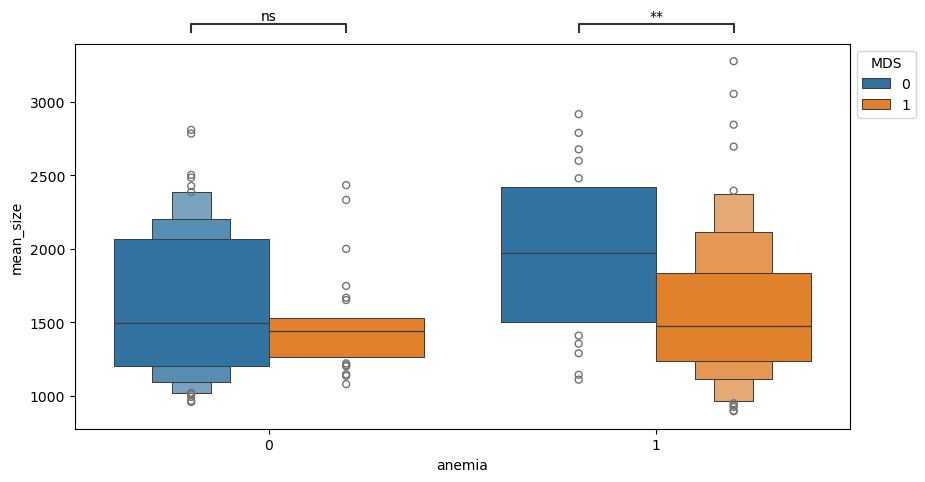

In [69]:
from statannotations.Annotator import Annotator
test = 'Mann-Whitney'

fig,ax = plt.subplots(1,1,figsize=(10,5))
#target='num_components' #
target='mean_size'
#target='area_ratio'

#hue_label=None
#hue_label='anemia'
hue_label='MDS'

#xlabel="MDS"
xlabel='anemia'

sns.boxenplot(data=dfs,x=xlabel,y=target,hue=hue_label,ax=ax)
#pairs = [ ((True,True),(False,True)),((True,False),(False,False)) ]
pairs = [ ((True,True),(True,False)),((False,True),(False,False)) ]
#pairs = [ (True,False) ]
annotator = Annotator(ax,pairs, data=dfs,x=xlabel,y=target,hue=hue_label, verbose=True)
annotator.configure(test=test, text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


# Misc

In [ ]:
timm.list_models('*efficient*', pretrained=True)

In [67]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_snapshot()

In [ ]:
torch.cuda.memory_stats()

In [ ]:
# stop 
from google.colab import runtime
runtime.unassign()
